In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPool2D, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model
import tensorflow.keras.metrics as km
import tensorflow.keras.backend as K

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
class IoU:
    def __init__(self, threshold=.5, name=None):
        self.threshold = threshold
        if name is None:
            name = "IoU"
        self.__name__ = name

    def __call__(self, y_true, y_pred):
        a = y_true == 1
        b = y_pred > self.threshold
        inter = tf.cast(tf.math.logical_and(a, b), "float32")
        union = tf.cast(tf.math.logical_or(a, b), "float32")
        return tf.reduce_sum(inter, axis=[1,2,3]) / tf.reduce_sum(union, axis=[1,2,3])

def dice_loss(y_true, y_pred):
  numerator = 2 * tf.reduce_mean(y_true * y_pred, axis=[1,2,3])
  denominator = tf.reduce_mean(y_true + y_pred, axis=[1,2,3])
  return 1 - numerator / denominator

In [12]:
input_shape = (128, 128, 3)

conv_args = dict(kernel_size=(3,3), padding="same", activation="relu")

in_unet = Input(input_shape)
x = Conv2D(32, **conv_args)(in_unet)
x1 = Conv2D(32, **conv_args)(x)
x = MaxPool2D()(x1)

x = Conv2D(64, **conv_args)(x)
x2 = Conv2D(64, **conv_args)(x)
x = MaxPool2D()(x2)

x = Conv2D(128, **conv_args)(x)
x3 = Conv2D(128, **conv_args)(x)
x = MaxPool2D()(x3)

x = Conv2D(256, **conv_args)(x)
x4 = Conv2D(256, **conv_args)(x)
x = MaxPool2D()(x4)

x = Conv2D(512, **conv_args)(x)
x = Conv2D(512, **conv_args)(x)

x = UpSampling2D()(x)
x = Concatenate(axis=-1)([x, x4])
x = Conv2D(256, **conv_args)(x)
x = Conv2D(256, **conv_args)(x)

x = UpSampling2D()(x)
x = Concatenate(axis=-1)([x, x3])
x = Conv2D(128, **conv_args)(x)
x = Conv2D(128, **conv_args)(x)

x = UpSampling2D()(x)
x = Concatenate(axis=-1)([x, x2])
x = Conv2D(64, **conv_args)(x)
x = Conv2D(64, **conv_args)(x)

x = UpSampling2D()(x)
x = Concatenate(axis=-1)([x, x1])
x = Conv2D(32, **conv_args)(x)
x = Conv2D(32, **conv_args)(x)

out_unet = Conv2D(1, kernel_size=(3,3), padding="same", activation="sigmoid")(x)

unet = Model(in_unet, out_unet)

In [6]:
eval_metrics = [
    IoU(name="IoU"),
    km.BinaryAccuracy(name="accuracy",),
    km.AUC(name="ROC_AUC", curve="ROC"),
    km.Precision(name="precision"),
    km.Recall(name="recall")
]

unet.compile(loss="binary_crossentropy", optimizer="rmsprop",
             metrics=eval_metrics)

In [8]:
import data_generation

train_gen = data_generation.SegmentationDataGenerator("../test_dataset/train")
test_gen = data_generation.SegmentationDataGenerator("../test_dataset/test")

Found 14896 files.
Found 4965 files.


In [8]:
history = unet.fit(train_gen, validation_data=test_gen, epochs=10)

Epoch 1/10
465/465 [==============================] - 105s 198ms/step - loss: 0.5888 - IoU: 0.0100 - accuracy: 0.9329 - ROC_AUC: 0.7223 - precision: 0.2410 - recall: 0.0172 - val_loss: 0.1761 - val_IoU: 0.0137 - val_accuracy: 0.9358 - val_ROC_AUC: 0.9077 - val_precision: 0.6036 - val_recall: 0.0230
Epoch 2/10
465/465 [==============================] - 88s 189ms/step - loss: 0.1701 - IoU: 0.1956 - accuracy: 0.9414 - ROC_AUC: 0.8806 - precision: 0.6065 - recall: 0.2698 - val_loss: 0.1305 - val_IoU: 0.4312 - val_accuracy: 0.9545 - val_ROC_AUC: 0.9529 - val_precision: 0.6357 - val_recall: 0.6951
Epoch 3/10
465/465 [==============================] - 88s 189ms/step - loss: 0.1422 - IoU: 0.3392 - accuracy: 0.9515 - ROC_AUC: 0.9194 - precision: 0.7060 - recall: 0.4304 - val_loss: 0.1342 - val_IoU: 0.4094 - val_accuracy: 0.9543 - val_ROC_AUC: 0.9432 - val_precision: 0.7976 - val_recall: 0.3942
Epoch 4/10
465/465 [==============================] - 88s 190ms/step - loss: 0.1092 - IoU: 0.4983 - ac

In [9]:
def plot_metric(name, history, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(history[name], label=name)
    ax.plot(history[f"val_{name}"], label=f"val_{name}")
    ax.legend()
    return ax

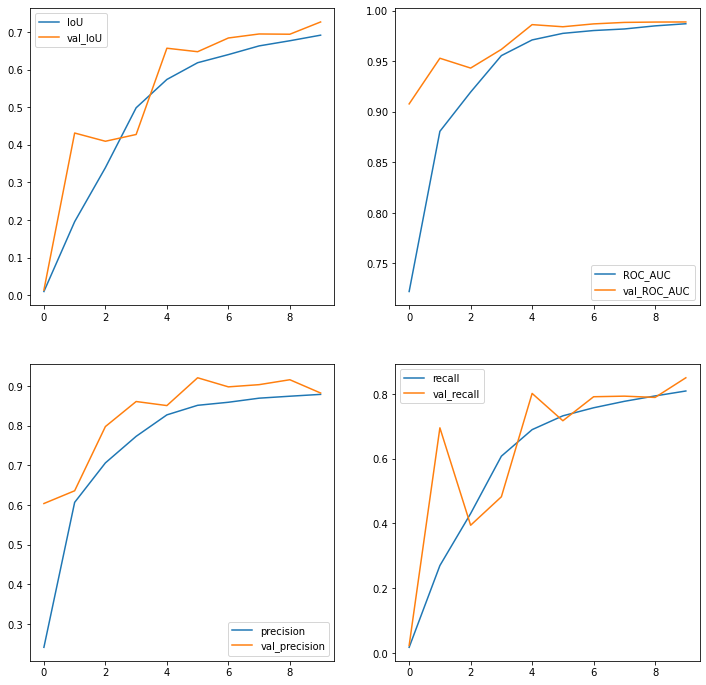

In [10]:
fig, ax = plt.subplots(2,2, figsize=(12,12))
H = history.history
plot_metric("IoU", H, ax[0,0])
plot_metric("ROC_AUC", H, ax[0,1])
plot_metric("precision", H, ax[1,0])
plot_metric("recall", H, ax[1,1])
plt.show()

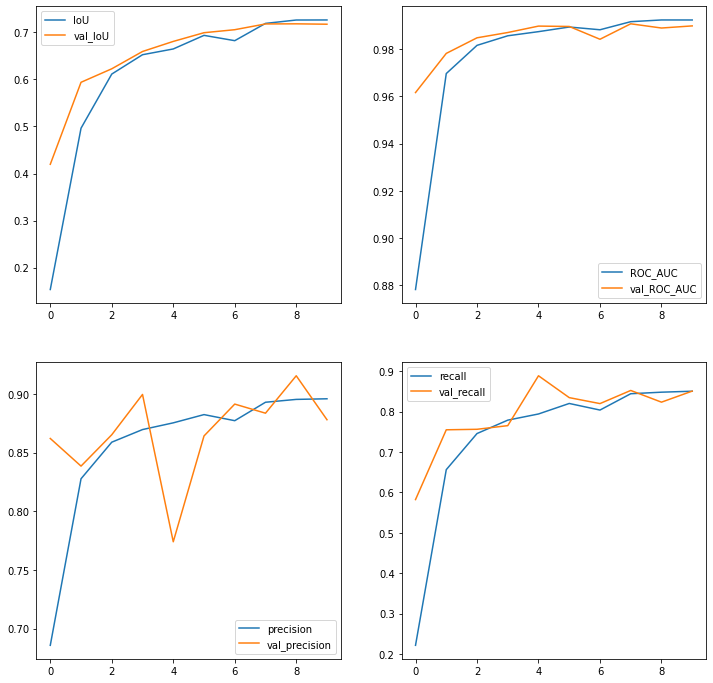

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(12,12))
H = history.history
plot_metric("IoU", H, ax[0,0])
plot_metric("ROC_AUC", H, ax[0,1])
plot_metric("precision", H, ax[1,0])
plot_metric("recall", H, ax[1,1])
plt.show()

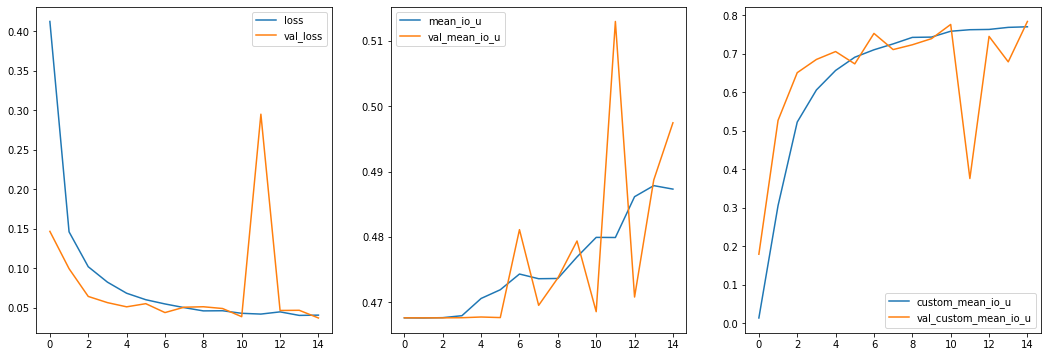

In [11]:
fig, ax = plt.subplots(1,3, figsize=(18,6))
H = history.history
ax[0].plot(H["loss"], label="loss")
ax[0].plot(H["val_loss"], label="val_loss")
ax[0].legend()
ax[1].plot(H["mean_io_u"], label="mean_io_u")
ax[1].plot(H["val_mean_io_u"], label="val_mean_io_u")
ax[1].legend()
ax[2].plot(H["custom_mean_io_u"], label="custom_mean_io_u")
ax[2].plot(H["val_custom_mean_io_u"], label="val_custom_mean_io_u")
ax[2].legend()
plt.show()

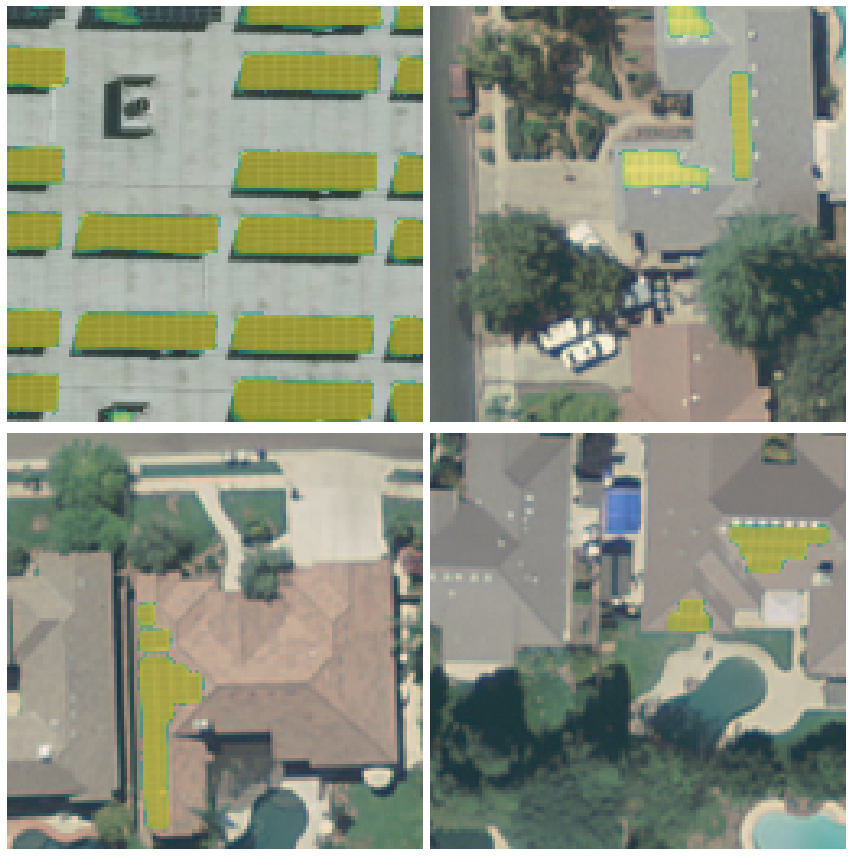

In [9]:
X, y = test_gen.__getitem__(0)
y_pred = unet.predict(X)

w, h = 2, 2
fig, ax = plt.subplots(h, w, figsize=(12,12))

for i in range(h):
    for j in range(w):
        ax[i,j].imshow(X[w*i+j])
        # ax[i,j].imshow(y[w*i+j,:,:,0], cmap="gray")
        ax[i,j].imshow(np.ma.masked_less(y_pred[w*i+j,:,:,0], .5), vmin=0, vmax=1, alpha=.5)
        # ax[i,j].imshow(y_pred[w*i+j,:,:,0], vmin=0, vmax=1, alpha=.5)
        ax[i,j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
eval_metrics = [
    IoU(name="IoU"),
    km.BinaryAccuracy(name="accuracy",),
    km.AUC(name="ROC_AUC", curve="ROC"),
    km.Precision(name="precision"),
    km.Recall(name="recall")
]

In [11]:
unet = keras.models.load_model("../trained_models/Unet/unet_v4.tf", custom_objects={"IoU":IoU})

In [12]:
unet.save(r"trained_models\Unet\unet_v4.tf")

INFO:tensorflow:Assets written to: trained_models\Unet\unet_v4.tf\assets


In [9]:
y_pred = unet.predict(test_gen)

ValueError: Found input variables with inconsistent numbers of samples: [524288, 81264640]

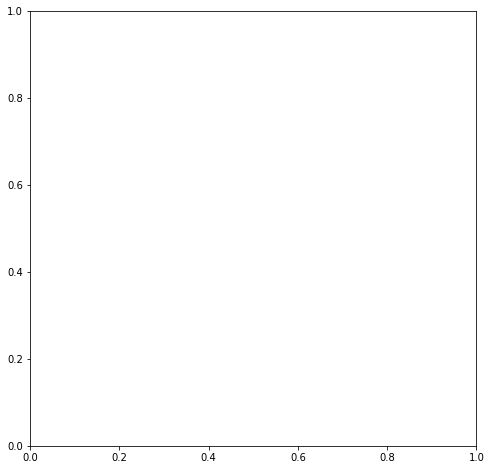

In [14]:
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize=(8,8))
RocCurveDisplay.from_predictions(y.reshape(-1), y_pred.reshape(-1), ax=ax)

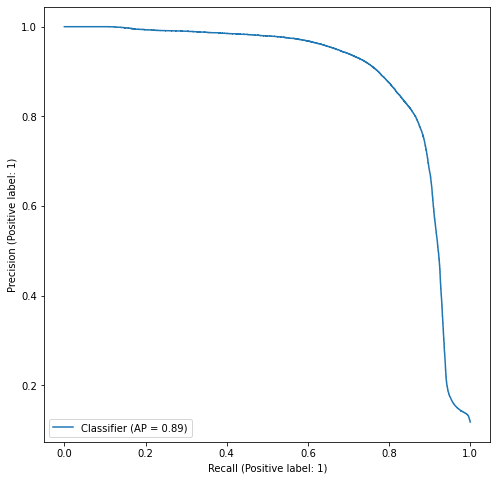

In [11]:
from sklearn.metrics import PrecisionRecallDisplay

fig, ax = plt.subplots(figsize=(8,8))
PrecisionRecallDisplay.from_predictions(y.reshape(-1), y_pred.reshape(-1), ax=ax)

# Test Gers Data

In [22]:
import data_generation

gers_gen = data_generation.SegmentationDataGenerator("./gers_dataset2")

Found 2232 files.


In [23]:
unet_eval = unet.evaluate(gers_gen)

69/69 [==============================] - 16s 236ms/step - loss: 0.1805 - IoU: 0.7031 - accuracy: 0.9450 - ROC_AUC: 0.9778 - precision: 0.8884 - recall: 0.8930


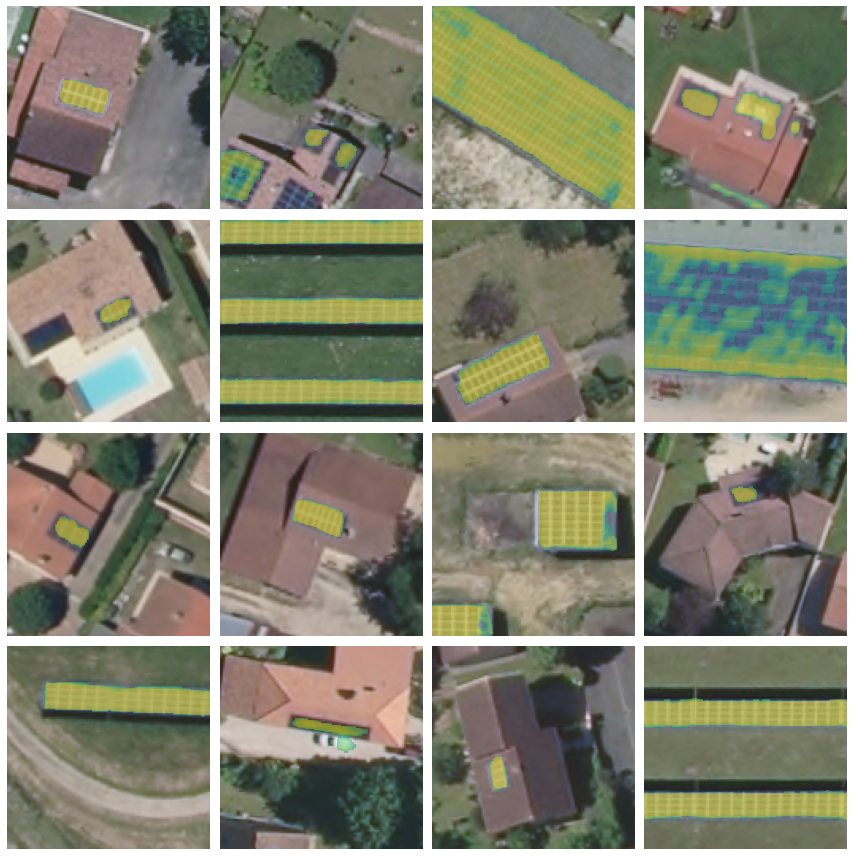

In [26]:
Xg, yg = gers_gen.__getitem__(57)
yg_pred = unet.predict(Xg)

w, h = 4, 4
fig, ax = plt.subplots(h, w, figsize=(12,12))

for i in range(h):
    for j in range(w):
        ax[i,j].imshow(Xg[w*i+j])
        # ax[i,j].imshow(y[w*i+j,:,:,0], cmap="gray")
        ax[i,j].imshow(np.ma.masked_less(yg_pred[w*i+j,:,:,0], .5), vmin=0, vmax=1, alpha=.5)
        # ax[i,j].imshow(y_pred[w*i+j,:,:,0], vmin=0, vmax=1, alpha=.5)
        ax[i,j].axis('off')

plt.tight_layout()
plt.show()